# Building a concept map
### Generating a graph of linked concepts
### Recommending learning paths based on student background

First we load extracted concepts from file. 

In [1]:
filename = 'starwiki'

concepts = {}
import pickle
# Loading extracted concepts from file (see concept_extraction.ipynb)
#concepts = {'sents':sents,'rawtxt':rawtxt,'sent_to_npflat':sent_to_npflat,'sent_to_tags':sent_to_tags,'sent_to_ltags':sent_to_ltags,'np_to_sent':np_to_sent,'Conceptdata':Conceptdata}
with open(filename +'concepts.pickle', 'rb') as f:
    concepts = pickle.load(f)
f.close()

# Loading idf dictionary (see Build_IDF_dictionary.ipynb)
with open('idf_dict.pickle','rb') as f1:
    idf_dict =pickle.load(f1)
f1.close()

sents = concepts['sents']
rawtxt = concepts['rawtxt']
sent_to_npflat = concepts['sent_to_npflat']
sent_to_tags= concepts['sent_to_tags']
sent_to_ltags = concepts['sent_to_ltags']
np_to_sent = concepts['np_to_sent']
Conceptdata = concepts['Conceptdata']

Function to get undirected graph between two concepts, weight value is inversely proportional to number of sentences between the two concepts. 

Bond strength = summation of 1/(1+sentence distance) for every time they occur within (max - min) sentence distance

1. max_sent_dist : the maximum sentence between first concept and second concept to consider as linked
2. min_sent_dist : (typically zero) minimum sentence distance between first and second concept to consider as linked
3. sent_to_npflat: dictionary : key: (sentence number in text), value: (list of concepts in the sentence) 


In [2]:
def build_graph(sent_to_npflat,max_sent_dist, min_sent_dist):
    npnp_bondstrengthdir = {}
    for i in range(len(sent_to_npflat)-max_sent_dist):
        for np1 in sent_to_npflat[i]:
            npnp_bondstrengthdir[np1] = {}
            for j in range(min_sent_dist, max_sent_dist):
                np2list = [np2 for np2 in sent_to_npflat[i+j] if np2!=np1]
                for np2 in np2list:
                    npnp_bondstrengthdir[np1][np2] =npnp_bondstrengthdir[np1].get(np2,0) + 1/(j+1)
    return npnp_bondstrengthdir

In [3]:
# Function for term frequency
def tf(np,rawtxt):
   p = re.compile(np)
   return len(p.findall(rawtxt.lower()))        

# Function for IDF
import math
totaldocs = 10788
def get_idf(wrd,totaldocs):
    wrd = wrd.lower()
    return idf_dict.get(wrd,math.log(totaldocs))


In [4]:
# function to find shortest distance (used for graph relationship weight calculations)
import bisect as bs

def find_shortest_distance(search_list, value):
    ins_point = bs.bisect_right(search_list,value)
    if ins_point < len(search_list):
        return min(abs(search_list[ins_point] - value), abs(search_list[ins_point - 1] - value))
    return abs(search_list[ins_point - 1] - value)


In [6]:
npnp_bondstrengthdir = build_graph(sent_to_npflat,3,0)

### Building a data frame with every relationship and metrics about individual concepts and their relationship

Metrics to calculate the importance of the individual concepts, importance of the relationship between them, and directionality.

Directionality: Does knowing ConceptA aid in understanding ConceptB? 

In [7]:
import itertools
from itertools import chain
import numpy as num

lensents = len(sents)
lennp = len(np_to_sent)
Concept1 = [[np1]*len(npnp_bondstrengthdir[np1]) for np1 in npnp_bondstrengthdir.keys()]
Concept1 = list(chain.from_iterable(Concept1))
Concept2 = [np2 for np1 in npnp_bondstrengthdir.keys() for np2 in npnp_bondstrengthdir[np1].keys()]

Bondstrength = [npnp_bondstrengthdir[Concept1[i]][Concept2[i]] for i in range(len(Concept1))]

# Number of sentences in which concept occurs
FA = [len(np_to_sent[np1]) for np1 in Concept1]
FB = [len(np_to_sent[np2]) for np2 in Concept2]

# std deviation of occurence of concept: the spread - does it occur all over the document or just in one section. 
SdevA = [num.std(np_to_sent[np1]) for np1 in Concept1]/lensents
SdevB = [num.std(np_to_sent[np2]) for np2 in Concept2]/lensents

## Computing the mean bond strength of concept X to other concepts (compared with Bondstrength, gives an idea of how 
## strongly X is related to Y in comparison with other concepts)
meanBSA = [num.mean(list(npnp_bondstrengthdir[np1].values())) for np1 in Concept1]
meanBSB = [num.mean(list(npnp_bondstrengthdir.get(np2,{}).values())) for np2 in Concept2]


## Computing average shortest distance of each A to a B and vice versa. A metric for co-occurence of the two concepts
OcA = [np_to_sent[np1] for np1 in Concept1]
OcB = [np_to_sent[np2] for np2 in Concept2]

dAB=[]
dBA=[]

for i in range(len(Concept1)):
    dAB.append(num.mean([abs(find_shortest_distance(OcB[i],o)) for o in OcA[i]]))
    dBA.append(num.mean([abs(find_shortest_distance(OcA[i],o)) for o in OcB[i]]))
    

## Computing number of mappings for Concept1, Concept2 respectively and how many of those concepts intersect
Amap = [len(npnp_bondstrengthdir[np1]) for np1 in Concept1]
Bmap = [len(npnp_bondstrengthdir.get(np2,{})) for np2 in Concept2]
AmapintersectBmap = [len(set(npnp_bondstrengthdir[Concept1[i]].keys()) & set(npnp_bondstrengthdir.get(Concept2[i],{}).keys())) for i in range(len(Concept1))]

## How many concepts is A linked to that B is NOT linked to, and vice versa
AminusB = [Amap[i]-AmapintersectBmap[i] for i in range(len(Concept1))]
BminusA = [Bmap[i]-AmapintersectBmap[i] for i in range(len(Concept1))]




## First occurence of A and B wrt length of text
AfirstOc = [np_to_sent[np1][0]/lensents for np1 in Concept1]
BfirstOc = [np_to_sent[np2][0]/lensents for np2 in Concept2]


## IDF value for each concept (1-gram IDF dictionary. using average for multi word concept phrases)
nptoWtkeys = list(np_to_sent.keys())
nptoWtvals = [np.split() for np in nptoWtkeys]
nptoWt = dict(zip(nptoWtkeys,nptoWtvals))
nptoIDFvals = [num.mean([get_idf(t,totaldocs) for t in nptoWt[np1]]) for np1 in nptoWt.keys()]
nptoIDF = dict(zip(nptoWtkeys,nptoIDFvals))
IDFA = [nptoIDF[np1] for np1 in Concept1]
IDFB = [nptoIDF[np2] for np2 in Concept2]

## Seeing if one concept phrase is present in the other: example: long-term memory, memory. 
AinB = [1 if Concept1 in Concept2 else 0 for i in range(len(Concept1))]
BinA = [1 if Concept2 in Concept1 else 0 for i in range(len(Concept1))]

C:\Users\Arati\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Arati\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
import pandas as pd
print('making into dataframe')

df = pd.DataFrame({'Concept1':Concept1,'Concept2': Concept2,'FA':FA,'FB':FB,'SdevA':SdevA,'SdevB':SdevB,'Bondstrength':Bondstrength, 'meanBSA':meanBSA, 'meanBSB':meanBSB,'dAB':dAB,'dBA':dBA,'Amap':Amap,'Bmap':Bmap,'AmapintersectBmap':AmapintersectBmap, 'AminusB':AminusB, 'BminusA':BminusA,'AfirstOc':AfirstOc,'BfirstOc':BfirstOc,'IDFA':IDFA,'IDFB':IDFB, 'AinB':AinB, 'BinA':BinA })

making into dataframe


In [12]:
# Looking at some of the concept1-concept2 links. 

print('Total number of relationships in graph', len(df))
df.sort_values(by=['FA','FB','SdevA','SdevB','Amap','Bmap'],ascending=[False]*6).head(20)

Total number of relationships in graph 21327


,Concept1,Concept2,FA,FB,SdevA,SdevB,Bondstrength,meanBSA,meanBSB,dAB,...,AmapintersectBmap,AminusB,BminusA,AfirstOc,BfirstOc,IDFA,IDFB,AinB,BinA,IDFdiff
47,star,core,173,35,119.580887,128.929786,0.333333,0.544872,0.702381,11.919075,...,14,12,14,0.0,0.014184,6.108136,5.524990,0,0,0.583146
45,star,mass,173,26,119.580887,129.345147,0.333333,0.544872,0.702381,7.728324,...,14,12,14,0.0,0.021277,6.108136,6.513601,0,0,0.405465
35,star,helium,173,20,119.580887,131.953780,0.833333,0.544872,0.702381,21.213873,...,14,12,14,0.0,0.014184,6.108136,9.286190,0,0,3.178054
28,star,energy,173,16,119.580887,146.334044,1.000000,0.544872,0.710526,27.606936,...,0,26,19,0.0,0.014184,6.108136,3.527288,0,0,2.580848
41,star,massive star,173,12,119.580887,82.898993,0.333333,0.544872,0.702381,33.109827,...,14,12,14,0.0,0.267139,6.108136,5.761562,0,0,0.346574
46,star,heavy element,173,11,119.580887,115.506288,0.333333,0.544872,0.702381,29.132948,...,14,12,14,0.0,0.030733,6.108136,4.947044,0,0,1.161092
33,star,more massive star,173,3,119.580887,128.124939,0.500000,0.544872,0.635417,64.393064,...,23,3,9,0.0,0.304965,6.108136,4.554181,0,0,1.553955
32,star,carbon,173,3,119.580887,116.201932,0.833333,0.544872,0.702381,77.335260,...,14,12,14,0.0,0.404255,6.108136,6.721240,0,0,0.613104
51,star,kelvin,173,3,119.580887,57.063318,0.333333,0.544872,0.702381,116.664740,...,14,12,14,0.0,0.697400,6.108136,8.187577,0,0,2.079442
27,star,reaction,173,3,119.580887,0.816497,1.500000,0.544872,0.635417,215.878613,...,23,3,9,0.0,0.981087,6.108136,5.081497,0,0,1.026639


## Concept importance, Relationship importance and Directionality hypotheses

Before we make the concept graph, we need to ensure the graph is directed and acyclic so it is clear which concept should be learned first, and which topic is more advanced. 

In the absence of annotated concept direction data, (plan to get 'prerequisite' and 'aiding word' information from wikipedia articles), for now, we can look at some hypotheses on directionality, and concept and relationship importance. 

### Concept importance: Is this an important concept in this text?
#### Hypotheses:
1. Higher TF value makes concept more important
2. Higher SdevA,SdevB : concepts are spread out throughout the text
3. Amap: how many concepts ConceptA maps to, the higher the more important the concept.  
4. AfirstOc: how early in the text does A appear
5. Higher Inverse Docuemnt Frequency value makes concept more important

Are all of the above correlated with each other? As in, are we including too many terms? 

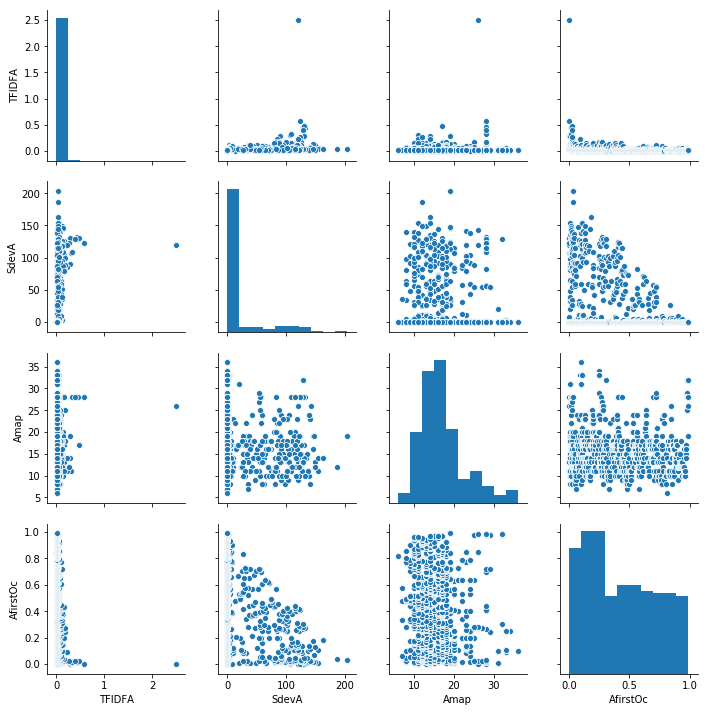

In [57]:
# subsetting concept1's metrics and dropping duplicates to avoid recounting
df['TFA'] = df['FA']/lensents
df['TFB'] = df['FB']/lensents
df['TFIDFA'] = df['TFA']*df['IDFA']
df['TFIDFB'] = df['TFB']*df['IDFB']
dfConceptimp = df.copy().loc[:,['Concept1','TFIDFA','SdevA','Amap','AfirstOc']].drop_duplicates()

import seaborn as sns
sns.pairplot(dfConceptimp)

In [58]:
dfConceptimp.sort_values(by=['TFIDFA','Amap','SdevA','AfirstOc'],ascending=[False,False,False,True]).head(25)

,Concept1,TFIDFA,SdevA,Amap,AfirstOc
26,star,2.498126,119.580887,26,0.000000
77,sun,0.578302,123.219255,28,0.002364
776,luminosity,0.482970,129.986466,17,0.021277
525,core,0.457150,128.929786,28,0.014184
497,helium,0.439063,131.953780,28,0.014184
820,mass,0.400363,129.345147,28,0.021277
588,hydrogen,0.325032,108.787188,28,0.014184
332,astronomer,0.307344,107.247853,11,0.009456
357,galaxy,0.290340,89.297406,19,0.011820
63,earth,0.289633,130.901955,14,0.002364


This seems to be a reasonable way to order concepts for their importance.

### Relationship importance: 
#### Hypotheses: 

1. The higher the bondstrength, the more important the relationship
2. Bondstrength - mean(meanBSA,meanBSB). If bondstrength between A-B is higher than the bondstrength of A with other concepts, and B with other concepts, then the relationship is important. 
3. Low values of min(dAB,dBA) (high co-occurence of A wrt B or B wrt A)
4. High value of AmapintersectBmap (A and B link to a lot of the same concepts)

In [59]:
df['Bondstrengthdiff'] = df['Bondstrength']-(df['meanBSA']+df['meanBSB'])/2
df['mean_dAB'] = (df['dAB']+df['dBA'])/2
dfRelImp = df.copy().loc[:,['Concept1','Concept2','mean_dAB','Bondstrengthdiff','AmapintersectBmap']]
dfRelImp.sort_values(by=['AmapintersectBmap','mean_dAB','Bondstrengthdiff'],ascending = [False,True,False]).head(40)

,Concept1,Concept2,mean_dAB,Bondstrengthdiff,AmapintersectBmap
2633,andromeda galaxy,brocchi,0.0,0.430556,35
2634,andromeda galaxy,persian astronomer abd,0.0,0.430556,35
2637,andromeda galaxy,omicron velorum,0.0,0.430556,35
2638,andromeda galaxy,fixed star,0.0,0.430556,35
2669,brocchi,andromeda galaxy,0.0,0.430556,35
2670,brocchi,persian astronomer abd,0.0,0.430556,35
2673,brocchi,omicron velorum,0.0,0.430556,35
2674,brocchi,fixed star,0.0,0.430556,35
2705,persian astronomer abd,andromeda galaxy,0.0,0.430556,35
2706,persian astronomer abd,brocchi,0.0,0.430556,35


### Directionality: 
Would knowing Concept A aid in understanding Concept B? 
It is difficult to define this - it could mean that Concept A is a pre-requisite for defining Concept B (temperature -> thermometer), or not, but still play an important role in the explanation. (winter -> thermometer)

After a point, it also depends on the student's background, and feedback would be required. 
Nevertheless, nothing is stopping us from making some rule-based decisions yet. 

#### Hypotheses:
1. Higher AminusB than BminusA, the more concepts A is linked to that B is not linked to, the more likely that A directs to B than vice versa 
2. Difference between dAB and dBA (if B co-occurs with A very often, but A does not, then A more likely directs to B, than vice versa
3. If the IDF value of A is lower than B, then A more likely directs to B, than vice versa
4. If AinB is 1, then A more likely directs to B than vice versa (Example: ConceptA:'memory', ConceptB 'traumatic memory')

In [71]:
df['AminusB_BminusA_diff'] = df['AminusB'] - df['BminusA']
df['dAB_dBA_diff'] = df['dAB']-df['dBA']
df['IDFA_IDFB_diff'] = df['IDFA']-df['IDFB']
dfDirectional = df.copy().loc[:,['Concept1','Concept2','AminusB_BminusA_diff','dAB_dBA_diff','IDFA_IDFB_diff','AinB']]
dfDirectional.sort_values(by = ['dAB_dBA_diff','IDFA_IDFB_diff','AminusB_BminusA_diff','AinB'],ascending=[False]*4).head(45)

,Concept1,Concept2,AminusB_BminusA_diff,dAB_dBA_diff,IDFA_IDFB_diff,AinB
1212,heavy element,so further energy,9,253.545455,1.799202,0
1223,heavy element,nuclear fuel,28,253.545455,-0.274558,0
1200,heavy element,contracting core,0,253.545455,-1.259598,0
1207,heavy element,intermediate element beryllium,0,253.545455,-1.777091,0
1214,heavy element,endothermic process,9,253.545455,-1.953803,0
1199,heavy element,triple-alpha process,0,253.545455,-1.953803,0
1202,heavy element,evolved star,0,253.545455,-2.403545,0
1210,heavy element,stellar nucleosynthesis process,9,253.545455,-2.748917,0
1215,heavy element,stable isotope iron-56,9,253.545455,-2.778435,0
1208,heavy element,overall reaction,0,249.318182,0.288129,0
